#### Artem Golotin
CS501R Lab 5

In [1]:
import tensorflow as tf

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Placeholders for data
I, O = 784, 10
x = tf.placeholder(tf.float32, shape=[None, I], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, O], name='output')


### Convolutional and max pooling functions
conv2d = lambda x, W: tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
max_pool_2x2 = lambda x: tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### First convolutional layer
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
# Reshape the input image to match the first convolutional input dimentions
x_image = tf.reshape(x, [-1,28,28,1]) # 28 - width, 28 - height, 1 - color channels
# Convolve x_imae with the weight tensor, add bias, apply ReLU and max pool
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second convolutional layer
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2)+ b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Fully connected layer
W_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) # Reshape the tensor from last pooling layer to a batch of vectors
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout layer to avoid overfitting and to calculate correct training accuracy
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout layer and final output
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))

y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_pred), reduction_indices=[1]))
# Train
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, epsilon=1e-4).minimize(cross_entropy)

# Accuracy calculation
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
from tqdm import tqdm
import numpy as np
from pdb import set_trace as debugger

predicted_accuracies = []
# Run the session
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    for epoch in tqdm(range(1000)):
        batch_x, batch_y = mnist.train.next_batch(100)
        grayscaled_x = np.apply_along_axis(np.subtract, 0, batch_x, np.average(batch_x, axis=1))
        train_x, train_y = np.vstack((batch_x, grayscaled_x)), np.vstack((batch_y, batch_y))
        
        train_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y, keep_prob: 1.0})
        predicted_accuracies.append(train_accuracy)
        
        sess.run(train_step, feed_dict={x: train_x, y_: train_y, keep_prob: 0.5})



100%|██████████| 1000/1000 [46:09<00:00,  2.23s/it]


In [5]:
import matplotlib.pyplot as plt

def plot_accuracy():
    x = range(1,1001)
    plt.plot(x, predicted_accuracies)
    plt.ylabel("Classification Accuracy (%)")
    plt.xlabel("Epoch")
    plt.show()


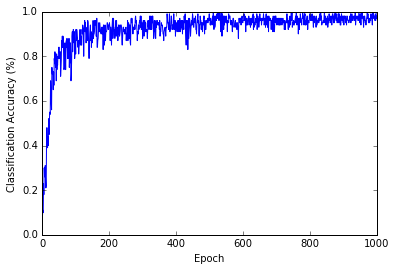

In [6]:
%matplotlib inline
plot_accuracy()